In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

#import graphviz
#import tensorflow as tf



from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
#iport data
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])


In [44]:
# Read in the time-series data train.csv and test.csv while parsing dates
train = pd.read_csv('./store-sales-time-series-forecasting/train.csv', index_col=[1], parse_dates=[1])



In [45]:
pjme.head(10)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


In [46]:
# Group by day, summing sales for train
train = train.groupby('date').sum()

# Remove onpromotion and store_nbr from the columns of train
train = train.drop(['onpromotion', 'store_nbr'], axis=1)


In [47]:
train.tail()

,id,sales
date,,
2017-08-11,5333291667,826373.722022
2017-08-12,5336467191,792630.535079
2017-08-13,5339642715,865639.677471
2017-08-14,5342818239,760922.406081
2017-08-15,5345993763,762661.935939


## EDA

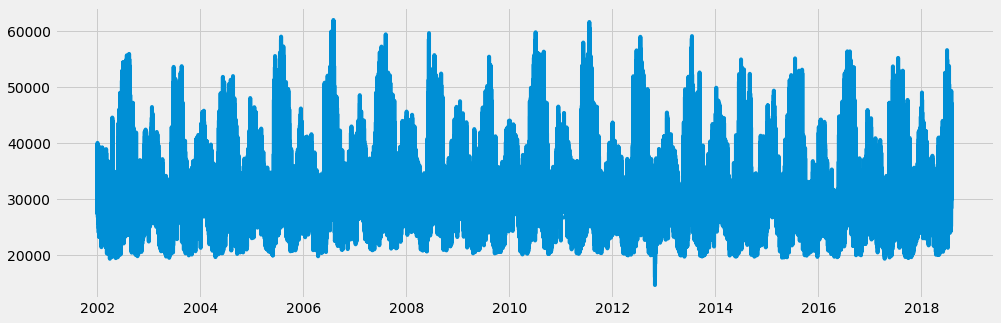

In [48]:
#Plot time-series
plt.figure(figsize=(15,5))
plt.plot(pjme.PJME_MW)

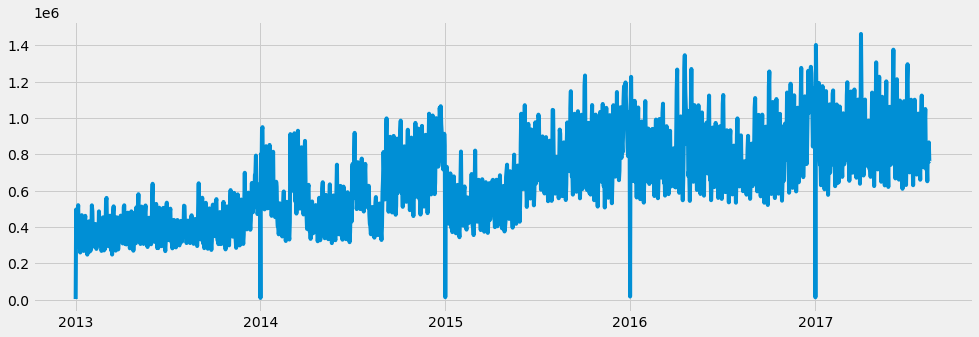

In [49]:
plt.figure(figsize=(15,5))
plt.plot(train.sales)

In [50]:
# what are possible candidates for further time-series plots?


## Split Data

In [54]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Find out which date is the 80th percentile of the data train
split_date_ = np.percentile(train.index, 80)
train_ = train.loc[train.index <= split_date].copy()
validate_ = train.loc[train.index > split_date].copy()

In [59]:
train_.tail()

,id,sales
date,,
2014-12-28,2300666247,716329.635071
2014-12-29,2303841771,773998.401175
2014-12-30,2307017295,912970.533204
2014-12-31,2310192819,844380.469674
2015-01-01,2313368343,12773.616980


In [60]:
#drop id from train_ and validate_
train_ = train_.drop(['id'], axis=1)
validate_ = validate_.drop(['id'], axis=1)


## Feature Engineering

In [8]:
# Feature Engineering
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [63]:
X_train, y_train = create_features(train_, label='sales')
X_test, y_test = create_features(validate_, label='sales')

/var/folders/j8/19vl2ybn33xf0x7k1_703k340000gp/T/ipykernel_3192/2818058950.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
/var/folders/j8/19vl2ybn33xf0x7k1_703k340000gp/T/ipykernel_3192/2818058950.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [64]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2013-01-01,0,1,1,1,2013,1,1,1
2013-01-02,0,2,1,1,2013,2,2,1
2013-01-03,0,3,1,1,2013,3,3,1
2013-01-04,0,4,1,1,2013,4,4,1
2013-01-05,0,5,1,1,2013,5,5,1
...,...,...,...,...,...,...,...,...
2014-12-28,0,6,4,12,2014,362,28,52
2014-12-29,0,0,4,12,2014,363,29,1
2014-12-30,0,1,4,12,2014,364,30,1


In [65]:
y_train

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2014-12-28    716329.635071
2014-12-29    773998.401175
2014-12-30    912970.533204
2014-12-31    844380.469674
2015-01-01     12773.616980
Name: sales, Length: 729, dtype: float64

## Train Model

In [80]:
reg = DecisionTreeRegressor(max_depth = 20)
reg.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=20)

In [81]:
# plt.figure(figsize=(10,8), dpi=150)

# plot_tree(reg, feature_names=X_train.columns, filled=True, rounded=True) 
# plt.show()



## Predict

In [82]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

In [83]:
validate_['sales_Prediction'] = reg.predict(X_test)

data_all = pd.concat([validate_, train_], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_Prediction
date,,,,,,,,,,,
2015-01-02,657763.391981,2015-01-02,0,4,1,1,2015,2,2,1,801011.226041
2015-01-03,648880.686926,2015-01-03,0,5,1,1,2015,3,3,1,936628.886604
2015-01-04,730923.776022,2015-01-04,0,6,1,1,2015,4,4,1,949618.788940
2015-01-05,569267.297960,2015-01-05,0,0,1,1,2015,5,5,2,602268.564009
2015-01-06,477886.741053,2015-01-06,0,1,1,1,2015,6,6,2,602268.564009
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,716329.635071,2014-12-28,0,6,4,12,2014,362,28,52,NaN
2014-12-29,773998.401175,2014-12-29,0,0,4,12,2014,363,29,1,NaN
2014-12-30,912970.533204,2014-12-30,0,1,4,12,2014,364,30,1,NaN


In [84]:
# Show rows which have an NaN in sales_Prediction
data_all[data_all['sales_Prediction'].isnull()]


,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_Prediction
date,,,,,,,,,,,
2013-01-01,2511.618999,2013-01-01,0,1,1,1,2013,1,1,1,NaN
2013-01-02,496092.417944,2013-01-02,0,2,1,1,2013,2,2,1,NaN
2013-01-03,361461.231124,2013-01-03,0,3,1,1,2013,3,3,1,NaN
2013-01-04,354459.677093,2013-01-04,0,4,1,1,2013,4,4,1,NaN
2013-01-05,477350.121229,2013-01-05,0,5,1,1,2013,5,5,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,716329.635071,2014-12-28,0,6,4,12,2014,362,28,52,NaN
2014-12-29,773998.401175,2014-12-29,0,0,4,12,2014,363,29,1,NaN
2014-12-30,912970.533204,2014-12-30,0,1,4,12,2014,364,30,1,NaN


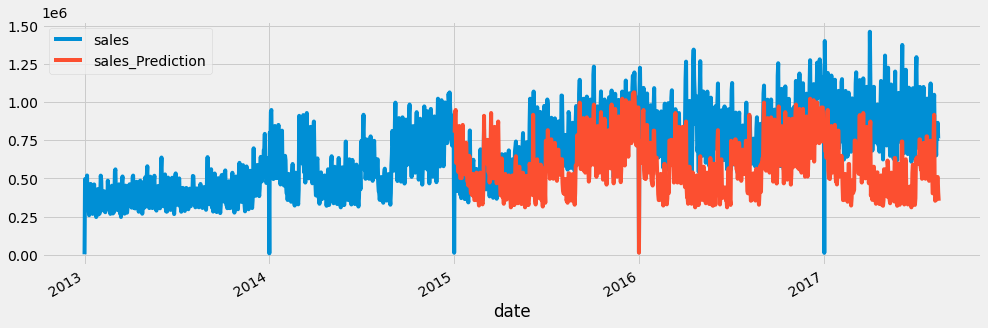

In [85]:
_ = data_all[['sales','sales_Prediction']].plot(figsize=(15, 5))


In [17]:
# Task: compare the result for decision trees, that differ in their complexity i.e. depth of the tree

## Prediction Error Analysis

In [86]:
validate_['error'] = validate_['sales'] - validate_['sales_Prediction']
validate_['abs_error'] = validate_['error'].apply(np.abs)
error_by_day = validate_.groupby(['year','month','dayofmonth']) \
    .mean()[['sales','sales_Prediction','error','abs_error']]



In [87]:
error_by_day.sort_values('error', ascending=True).head(10)

# 2015-12-25 (Christmas) and 2017-05-29 (memorial day holiday) are holidays in America -> maybe add holiday feature

sales  sales_Prediction          error  \
year month dayofmonth                                                   
2017 1     1            12082.500997     742732.830236 -730650.329239   
2015 3     5           428599.809059     741756.416525 -313156.607466   
     1     3           648880.686926     936628.886604 -287748.199678   
     3     15          662700.871933     929808.492772 -267107.620839   
           4           483330.548167     748930.902096 -265600.353929   
           3           492365.240830     748930.902096 -256565.661266   
           29          641213.770163     873958.839642 -232745.069479   
           28          589854.704057     822333.142686 -232478.438628   
     1     4           730923.776022     949618.788940 -218695.012918   
           8           417482.689131     636176.853478 -218694.164347   

                           abs_error  
year month dayofmonth                 
2017 1     1           730650.329239  
2015 3     5           313156.607466  
     1     3           287748.199678  
     3     15          267107.620839  
           4           265600.353929  
           3           256565.661266  
           29          232745.069479  
           28          232478.438628  
     1     4           218695.012918  
           8           218694.164347

## Random Forest

In [88]:
rf = RandomForestRegressor()

In [89]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [90]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [91]:
validate_['sales'] = rf.predict(X_test)

data_all = pd.concat([validate_, train_], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_Prediction,error,abs_error
date,,,,,,,,,,,,,
2015-01-02,475568.700295,2015-01-02,0,4,1,1,2015,2,2,1,801011.226041,-143247.834060,143247.834060
2015-01-03,907805.252584,2015-01-03,0,5,1,1,2015,3,3,1,936628.886604,-287748.199678,287748.199678
2015-01-04,914483.569720,2015-01-04,0,6,1,1,2015,4,4,1,949618.788940,-218695.012918,218695.012918
2015-01-05,537985.143071,2015-01-05,0,0,1,1,2015,5,5,2,602268.564009,-33001.266049,33001.266049
2015-01-06,528100.304906,2015-01-06,0,1,1,1,2015,6,6,2,602268.564009,-124381.822956,124381.822956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,716329.635071,2014-12-28,0,6,4,12,2014,362,28,52,NaN,NaN,NaN
2014-12-29,773998.401175,2014-12-29,0,0,4,12,2014,363,29,1,NaN,NaN,NaN
2014-12-30,912970.533204,2014-12-30,0,1,4,12,2014,364,30,1,NaN,NaN,NaN


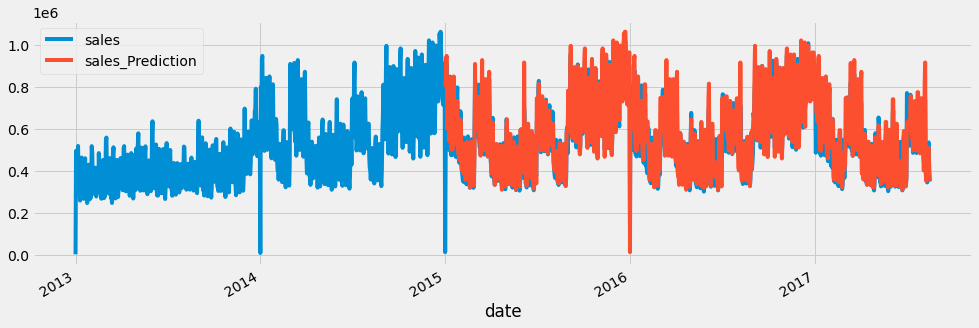

In [92]:
_ = data_all[['sales','sales_Prediction']].plot(figsize=(15, 5))


In [25]:
## Perform Hyeroarameter Tuning for the Random Forest. Use different approaches 
#(random search, grid search, Sequantial Model Based Optimization and a Genetic Algorithm)

In [ ]:
# Random Search


In [93]:
# Perform a grid search for the best parameters for the random forest
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)
                            
grid_search.fit(X_train, y_train)

grid_search.best_params_

# Use this grid_search.best_params_ to create a new random forest with the best parameters
rf = RandomForestRegressor(bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000)



Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] E

In [95]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=1000)

In [96]:
# Define mean_squared_log_error
from sklearn.metrics import mean_squared_log_error

# Get the Root Mean Squared Logarithmic Error (RMSLE) for the random forest
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Get the RMSLE for the random forest on the test data
rmsle(y_test, rf.predict(X_test))

# Get the RMSLE for the random forest on the train data
rmsle(y_train, rf.predict(X_train))



0.27416784190891913

In [97]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [98]:
validate_['sales'] = rf.predict(X_test)

data_all = pd.concat([validate_, train_], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_Prediction,error,abs_error
date,,,,,,,,,,,,,
2015-01-02,470732.664871,2015-01-02,0,4,1,1,2015,2,2,1,801011.226041,-143247.834060,143247.834060
2015-01-03,720188.603438,2015-01-03,0,5,1,1,2015,3,3,1,936628.886604,-287748.199678,287748.199678
2015-01-04,739512.703215,2015-01-04,0,6,1,1,2015,4,4,1,949618.788940,-218695.012918,218695.012918
2015-01-05,539816.704456,2015-01-05,0,0,1,1,2015,5,5,2,602268.564009,-33001.266049,33001.266049
2015-01-06,536219.241476,2015-01-06,0,1,1,1,2015,6,6,2,602268.564009,-124381.822956,124381.822956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28,716329.635071,2014-12-28,0,6,4,12,2014,362,28,52,NaN,NaN,NaN
2014-12-29,773998.401175,2014-12-29,0,0,4,12,2014,363,29,1,NaN,NaN,NaN
2014-12-30,912970.533204,2014-12-30,0,1,4,12,2014,364,30,1,NaN,NaN,NaN


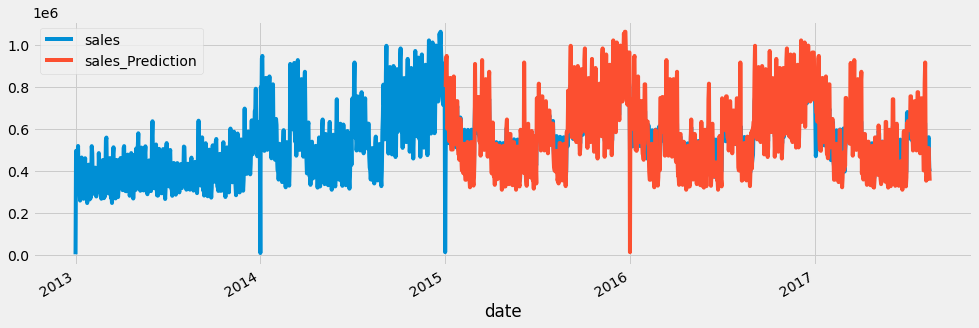

In [99]:
_ = data_all[['sales','sales_Prediction']].plot(figsize=(15, 5))
